## Sample radiation therapy optimization

In this demo, we illustrate a few simple examples of plan optimization for radiation therapy. We start by importing the needed packages:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append("../../therapy_planner")
from therapy_planner.interface import PlannerInterface
import numpy as np

The user begins by creating a plan through the `PlannerInterface` Class by supplying an input file of the target, maximum, and minimum radiation doses (Gy) to be delivered to an $m\times{n}$ [cm$^2$] region. Here we get the target, max, and min maps, and visualize the specified doses.

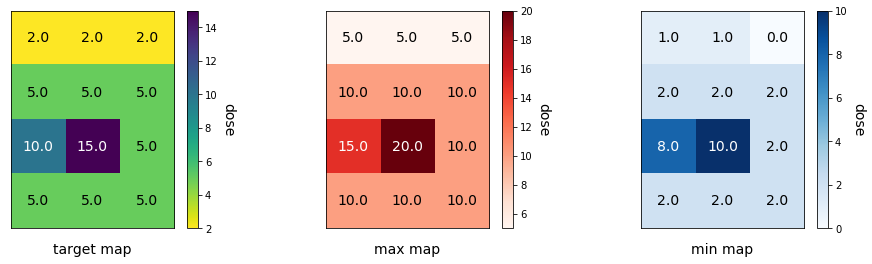

In [2]:
m = 4
n = 3
plan = PlannerInterface("dose_4x3.map")
maps = plan.get_maps()

fig, axes = plt.subplots(1,3,figsize=(16,4))
cmaps = ["viridis_r", "Reds", "Blues"]
for key, ax, cmap in zip(maps.keys(),axes.flat,cmaps):
    plan.plot_map(key, ax, cmap)
plt.show()

Next we run the `optimize` method of the `PlannerInterface` Class outlined in the `interface` module. The required input is the incident beam intensity, in mW, of the horizontal and vertical beams (assumed equal), which is used to optimize two quantities:
1. horizontal and vertical beam exposure times
2. sequence of collimator apertures for each beam, adjusted over the course of exposure, to tune the amount of radiation delivered to specific regions.

By setting `bounds=True`, we include a penalty term for optimized dose maps whose values lie outside of the provided minimum and maximum values. The smoothness (default 1) adjusts how strongly those bounds are enforced; a lower smoothness more strictly enforces these constraints, but is also more prone to numerical instability.

The `optimize` method computes the optimized dose map and the horizontal and vertical beam objects, whose attributes include the beam intensity and exposure time, intermediate "beamlets" used to solve for the collimator apertures, and the sequence of left and right collimator positions. In addition, the `print_summary()` method prints a summary of several useful aspects of the plan.

Minimum found.
Time Elapsed: 0.7664 sec.


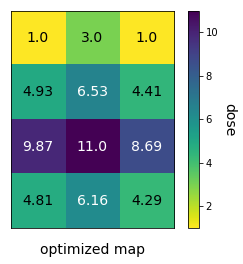

Horizontal beam intensity: 1.00 mW/cm^2
Horizontal beam exposure time: 9 sec.
Vertical beam intensity: 1.00 mW/cm^2
Vertical beam exposure time: 3 sec.
Total accumulated dose: 65.69 Gy
Average dose per unit area: 5.47 Gy/cm^2



In [3]:
plan.optimize(intensity=1., bounds=True, smoothness=0.5)
plan.plot_map("optimized")

plan.print_summary()

Below we visualize the adjustment of the collimator apertures over the course of the exposure time to achieve the desired dose. For example, we can observe that the second slot of the vertical beam collimator remains exposed to radiation over the full exposure time, and is in fact the column which receives the highest dose.

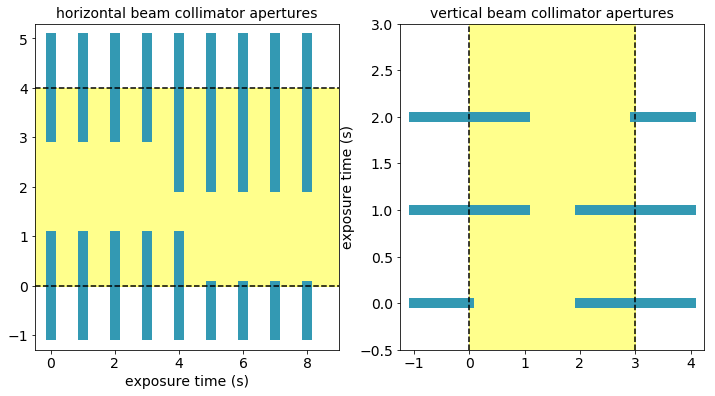

In [4]:
plan.plot_collimators()

We can also observe the effect of decreasing the intensity, which permits a longer exposure time for dose delivery.

Minimum found.
Time Elapsed: 0.7531 sec.


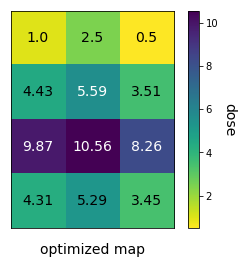

Horizontal beam intensity: 0.50 mW/cm^2
Horizontal beam exposure time: 18 sec.
Vertical beam intensity: 0.50 mW/cm^2
Vertical beam exposure time: 5 sec.
Total accumulated dose: 59.28 Gy
Average dose per unit area: 4.94 Gy/cm^2



In [5]:
plan.optimize(intensity=0.5, bounds=True, smoothness=0.5)
plan.plot_map("optimized")

plan.print_summary()

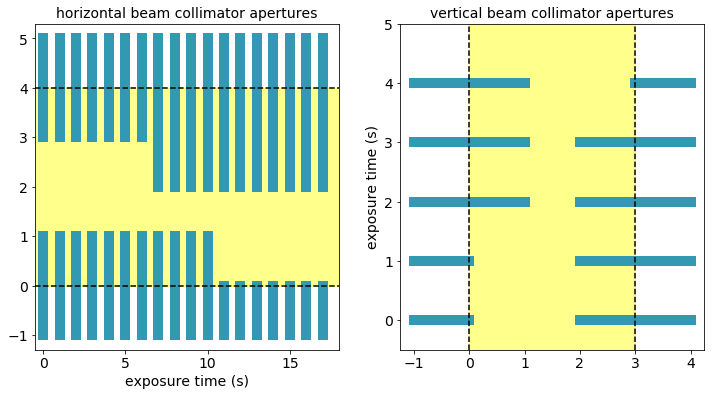

In [6]:
plan.plot_collimators()

We can also allow rotation of the maps in order to achieve minimum cost among all 4 rotations, by setting `allow_rotation` to `True`.

Optimize for rotation: 0 degrees
Minimum found.
Negative beamlet value detected. Suggestion: Adjust the smoothness.
Optimize for rotation: 90 degrees
Minimum found.
Negative beamlet value detected. Suggestion: Adjust the smoothness.
Optimize for rotation: 180 degrees
Minimum found.
Optimize for rotation: 270 degrees
Minimum found.
Found best rotation (counter-clockwise): 270 degrees
Time Elapsed: 2.3033 sec.


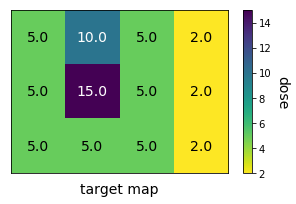

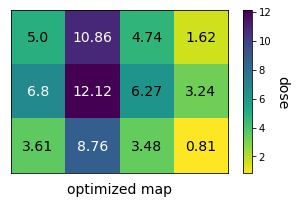

Maps are rotated for optimality.
Optimal rotation (counter-clockwise): 270 degrees
Horizontal beam intensity: 1.00 mW/cm^2
Horizontal beam exposure time: 4 sec.
Vertical beam intensity: 1.00 mW/cm^2
Vertical beam exposure time: 9 sec.
Total accumulated dose: 67.31 Gy
Average dose per unit area: 5.61 Gy/cm^2



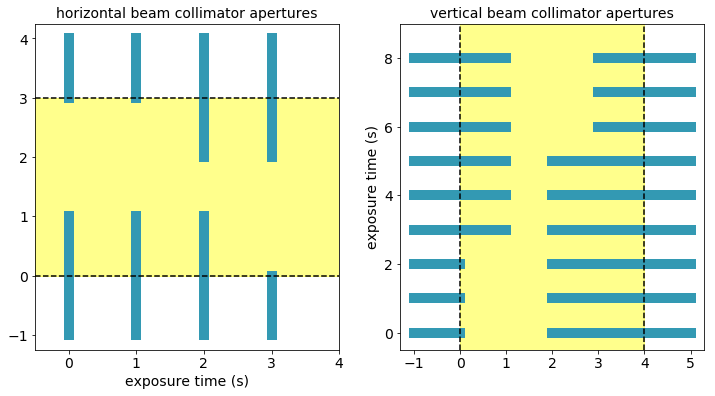

In [7]:
plan.optimize(intensity=1., bounds=True, allow_rotation=True)
plan.plot_map("target")
plan.plot_map("optimized")
plan.print_summary()
plan.plot_collimators()

The input maps may also have missing values, as shown in the modified example below. The `optimize` routine will obtain the best solution using only the available constraints.

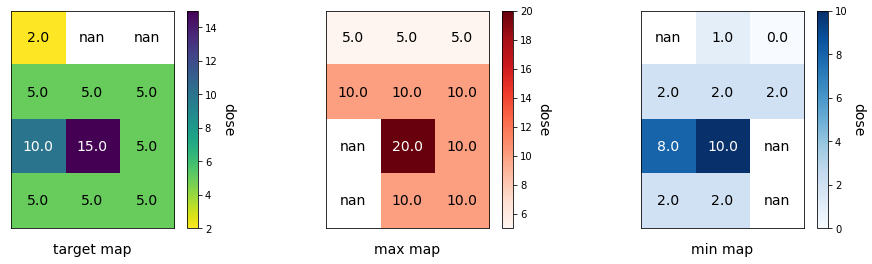

In [8]:
plan = PlannerInterface("dose_4x3_NaN.map")
maps = plan.get_maps()

fig, axes = plt.subplots(1,3,figsize=(16,4))
cmaps = ["viridis_r", "Reds", "Blues"]
for key, ax, cmap in zip(maps.keys(),axes.flat,cmaps):
    plan.plot_map(key, ax, cmap)
plt.show()

Optimize for rotation: 0 degrees
Minimum found.
Optimize for rotation: 90 degrees
Minimum found.
Negative beamlet value detected. Suggestion: Adjust the smoothness.
Optimize for rotation: 180 degrees
Minimum found.
Optimize for rotation: 270 degrees
Minimum found.
Found best rotation (counter-clockwise): 270 degrees
Time Elapsed: 1.8896 sec.


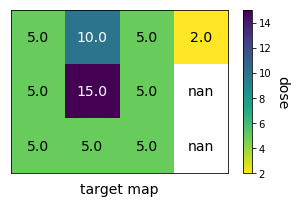

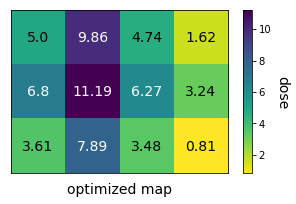

Maps are rotated for optimality.
Optimal rotation (counter-clockwise): 270 degrees
Horizontal beam intensity: 1.00 mW/cm^2
Horizontal beam exposure time: 4 sec.
Vertical beam intensity: 1.00 mW/cm^2
Vertical beam exposure time: 8 sec.
Total accumulated dose: 64.51 Gy
Average dose per unit area: 5.38 Gy/cm^2



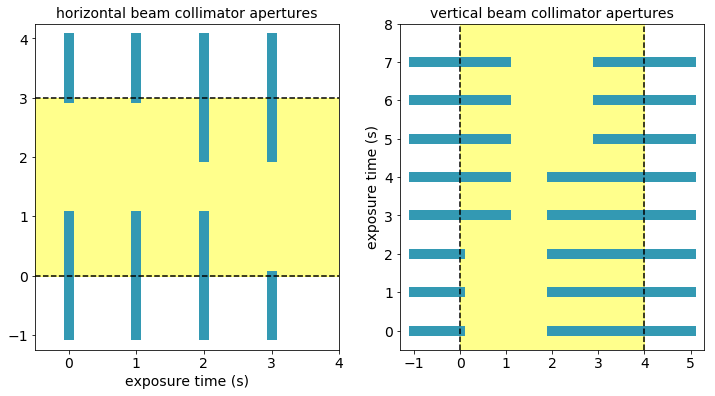

In [9]:
plan.optimize(intensity=1., bounds=True, allow_rotation=True)
plan.plot_map("target")
plan.plot_map("optimized")
plan.print_summary()
plan.plot_collimators()

As a final example, we next test a larger map:

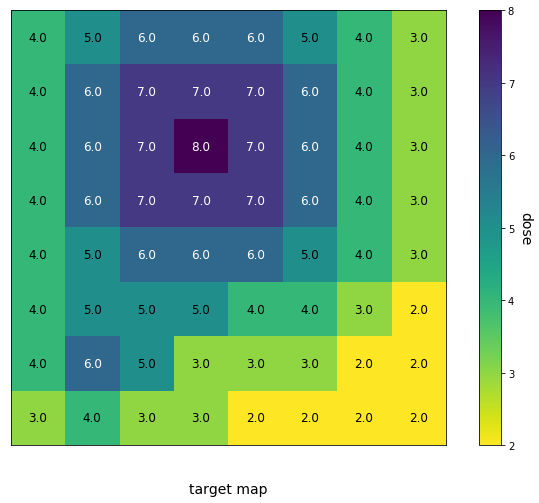

In [10]:
m = 8
n = 8
plan = PlannerInterface("dose_8x8.map")
plan.plot_map("target",fontsize=12)

In [11]:
plan.optimize(intensity=0.2, bounds=True)

Minimum found.
Time Elapsed: 25.0144 sec.


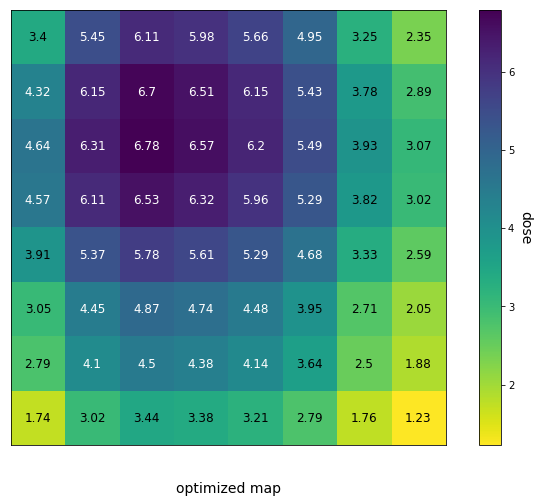

Horizontal beam intensity: 0.20 mW/cm^2
Horizontal beam exposure time: 18 sec.
Vertical beam intensity: 0.20 mW/cm^2
Vertical beam exposure time: 21 sec.
Total accumulated dose: 279.07 Gy
Average dose per unit area: 4.36 Gy/cm^2



In [12]:
plan.plot_map("optimized", fontsize=12)
plan.print_summary()

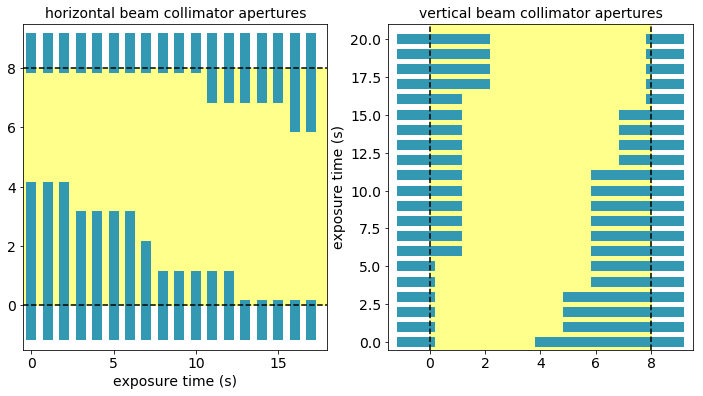

In [13]:
plan.plot_collimators()

We can also plot the difference between the optimized dose map and the target map to highlight over and underdosed regions, as well as the error (magnitude of the difference plot).

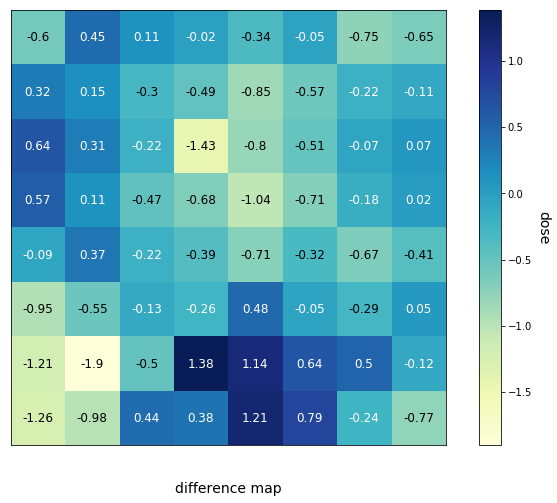

In [14]:
plan.plot_map("difference", cmap='YlGnBu', fontsize=12)

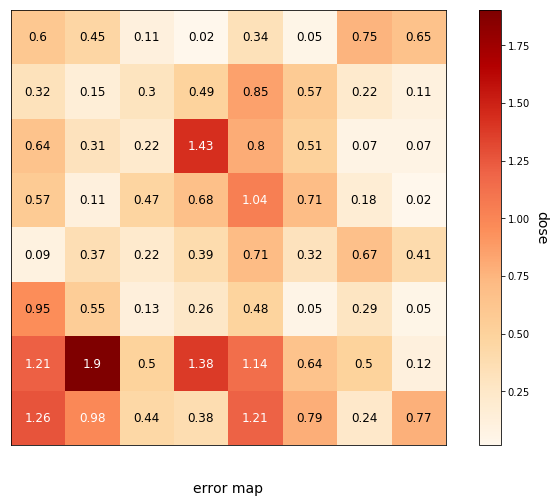

In [15]:
plan.plot_map("error", cmap='OrRd', fontsize=12)